Compression of MobileNetV2 on CIFAR-10 dataset

In [2]:
import argparse
import os
import time

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [3]:
# ---------------------------------
# Reproducibility Configuration
# ---------------------------------
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    """
    Sets seed for reproducibility across:
    - Python
    - NumPy
    - PyTorch (CPU + GPU)
    - cuDNN (deterministic)
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make cuDNN deterministic (slower but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Ensure hash-based ops are deterministic
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set to: {seed}")

# Call the seed function
set_seed(42)

Random seed set to: 42


In [3]:
import os
os.environ["WANDB_API_KEY"] = "c2389806cf212018d5d78267134864de6e052098"
import wandb

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
def create_mobilenetv2_cifar10(num_classes=10, pretrained=True):
    """
    Create a MobileNetV2 model adapted for CIFAR-10.
    """
    if pretrained:
        print("Load ImageNet weights")
        weights = MobileNet_V2_Weights.IMAGENET1K_V1
        model = mobilenet_v2(weights=weights)
    else:
        model = mobilenet_v2(weights=None)

    # Replace classifier (last linear layer) for CIFAR-10
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


In [5]:
def get_cifar10_loaders(data_dir, batch_size=128, num_workers=4):
    """
    Returns (trainloader, testloader) for CIFAR-10 with good augmentations.
    """
    # ImageNet-like normalization
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # CIFAR-10 images are 32x32; we upscale to 224x224 for MobileNetV2
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        normalize,
        transforms.RandomErasing(p=0.2)
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=train_transform
    )

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=test_transform
    )

    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return trainloader, testloader


In [6]:
class MovingAveragePerChannelObserver(nn.Module):
    """
    Tracks a moving-average of per-channel max-abs values.
    Used to stabilize activation quantization (less noisy than per-batch).
    """
    def __init__(self, channel_dim: int, momentum: float = 0.1, eps: float = 1e-8):
        super().__init__()
        self.channel_dim = channel_dim
        self.momentum = momentum
        self.eps = eps
        self.register_buffer("running_max", None)     # shape: 1 x C x 1 x 1 (or similar)
        self.register_buffer("initialized", torch.tensor(False))

    @torch.no_grad()
    def update(self, x: torch.Tensor):
        # Compute current per-channel max-abs over all non-channel dims
        dims = [d for d in range(x.dim()) if d != self.channel_dim]
        cur_max = x.detach().abs().amax(dim=dims, keepdim=True)  # shape compatible with x

        if not self.initialized:
            self.running_max = cur_max
            self.initialized.fill_(True)
        else:
            self.running_max = (
                (1.0 - self.momentum) * self.running_max
                + self.momentum * cur_max
            )

        # avoid zeros for scale computation
        self.running_max = torch.clamp(self.running_max, min=self.eps)

    @torch.no_grad()
    def get_scale(self, bit_width: int) -> torch.Tensor:
        qmax = 2 ** (bit_width - 1) - 1
        return self.running_max / qmax


class PerChannelWeightFakeQuant(nn.Module):
    """
    Per-channel symmetric fake quantization for weights.
    Uses the current weight tensor statistics (no moving-average observer).
    """
    def __init__(self, bit_width=8, channel_dim=0, eps: float = 1e-8):
        super().__init__()
        assert bit_width >= 2, "bit_width must be >= 2"
        self.bit_width = bit_width
        self.channel_dim = channel_dim
        self.eps = eps

    def forward(self, w: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # per-channel max-abs over all non-channel dims
            dims = [d for d in range(w.dim()) if d != self.channel_dim]
            max_val = w.detach().abs().amax(dim=dims, keepdim=True)
            max_val = torch.clamp(max_val, min=self.eps)

            qmax = 2 ** (self.bit_width - 1) - 1
            scale = max_val / qmax

            w_int = torch.clamp(torch.round(w / scale), -qmax - 1, qmax)
            w_dequant = w_int * scale

        # STE: forward uses quantized value, backward ~ identity
        w_ste = w + (w_dequant - w).detach()
        return w_ste


class PerChannelActivationFakeQuant(nn.Module):
    """
    Per-channel symmetric fake quantization for activations
    using a moving-average per-channel observer + STE.
    """
    def __init__(self, bit_width=8, channel_dim=1, momentum: float = 0.1):
        super().__init__()
        assert bit_width >= 2, "bit_width must be >= 2"
        self.bit_width = bit_width
        self.channel_dim = channel_dim
        self.observer = MovingAveragePerChannelObserver(
            channel_dim=channel_dim,
            momentum=momentum,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # update observer from current batch
        self.observer.update(x)

        with torch.no_grad():
            scale = self.observer.get_scale(self.bit_width)
            qmax = 2 ** (self.bit_width - 1) - 1
            x_int = torch.clamp(torch.round(x / scale), -qmax - 1, qmax)
            x_dequant = x_int * scale

        # STE: forward uses quantized value, backward ~ identity
        x_ste = x + (x_dequant - x).detach()
        return x_ste



class QuantizedConv2d(nn.Module):
    """
    Wraps nn.Conv2d to apply per-channel fake weight + activation quantization.
    - Weights: per-output-channel (dim=0)
    - Activations: per-input-channel (NCHW, dim=1)
    """
    def __init__(self, conv: nn.Conv2d, w_bits=8, a_bits=8):
        super().__init__()
        # copy original conv hyperparameters
        self.in_channels = conv.in_channels
        self.out_channels = conv.out_channels
        self.kernel_size = conv.kernel_size
        self.stride = conv.stride
        self.padding = conv.padding
        self.dilation = conv.dilation
        self.groups = conv.groups
        self.bias_flag = conv.bias is not None

        # actual conv that holds params
        self.conv = nn.Conv2d(
            conv.in_channels,
            conv.out_channels,
            kernel_size=conv.kernel_size,
            stride=conv.stride,
            padding=conv.padding,
            dilation=conv.dilation,
            groups=conv.groups,
            bias=self.bias_flag,
        )

        # copy weights/bias
        self.conv.weight.data.copy_(conv.weight.data)
        if self.bias_flag:
            self.conv.bias.data.copy_(conv.bias.data)

        # per-channel fake quant:
        #   weights: [out_channels, in_channels/groups, kH, kW] -> channel_dim=0
        #   activations: [N, C, H, W] -> channel_dim=1
        
        # weights: per-output-channel (dim=0)
        self.w_fake_quant = PerChannelWeightFakeQuant(
            bit_width=w_bits,
            channel_dim=0,
        )
        # activations: per-channel (NCHW -> dim=1) with moving-average observer
        self.a_fake_quant = PerChannelActivationFakeQuant(
            bit_width=a_bits,
            channel_dim=1,
            momentum=0.1,  # can tune this if required
        )

    def forward(self, x):
        # activation per-channel fake quant
        x = self.a_fake_quant(x)

        # weight per-channel fake quant
        w_q = self.w_fake_quant(self.conv.weight)
        b = self.conv.bias
        x = nn.functional.conv2d(
            x, w_q, b,
            stride=self.conv.stride,
            padding=self.conv.padding,
            dilation=self.conv.dilation,
            groups=self.conv.groups,
        )
        return x


class QuantizedLinear(nn.Module):
    """
    Wraps nn.Linear to apply per-channel fake weight + activation quantization.
    - Weights: per-output-channel (dim=0)
    - Activations: per-feature (dim=1) with moving-average observer.
    """
    def __init__(self, linear: nn.Linear, w_bits=8, a_bits=8):
        super().__init__()
        self.linear = nn.Linear(
            linear.in_features,
            linear.out_features,
            bias=(linear.bias is not None),
        )
        self.linear.weight.data.copy_(linear.weight.data)
        if linear.bias is not None:
            self.linear.bias.data.copy_(linear.bias.data)

        # weights: [out_features, in_features] -> dim=0
        self.w_fake_quant = PerChannelWeightFakeQuant(
            bit_width=w_bits,
            channel_dim=0,
        )
        # activations: [N, F] -> dim=1 with moving-average observer
        self.a_fake_quant = PerChannelActivationFakeQuant(
            bit_width=a_bits,
            channel_dim=1,
            momentum=0.1,
        )

    def forward(self, x):
        x = self.a_fake_quant(x)
        w_q = self.w_fake_quant(self.linear.weight)
        b = self.linear.bias
        return nn.functional.linear(x, w_q, b)


def apply_qat_wrapping(
    model: nn.Module,
    w_bits: int = 8,
    a_bits: int = 8,
    skip_first_last: bool = False,
):
    """
    Recursively replace Conv2d / Linear with QuantizedConv2d / QuantizedLinear.

    If skip_first_last=True:
      - do NOT quantize the very first Conv2d encountered
      - do NOT quantize the very last Linear encountered
    """

    # Count total convs/linears so we know which ones are "first" and "last"
    total_convs = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
    total_linears = sum(1 for m in model.modules() if isinstance(m, nn.Linear))

    counters = {"conv": 0, "linear": 0}

    def _wrap(module: nn.Module):
        for name, child in list(module.named_children()):
            # Recurse first
            _wrap(child)

            # Then possibly replace leaf modules
            if isinstance(child, nn.Conv2d):
                counters["conv"] += 1

                if skip_first_last:
                    # Skip the very first conv
                    if counters["conv"] == 1:
                        continue
                    # (optional) you could also skip the very last conv here if desired
                # Quantize all other convs
                setattr(module, name, QuantizedConv2d(child, w_bits, a_bits))

            elif isinstance(child, nn.Linear):
                counters["linear"] += 1

                if skip_first_last:
                    # Skip the very last linear
                    if counters["linear"] == total_linears:
                        continue
                    # (optional) you could also skip the first linear if you wanted
                # Quantize all other linears
                setattr(module, name, QuantizedLinear(child, w_bits, a_bits))

    _wrap(model)
    return model


def estimate_model_size_mb(
    model: nn.Module,
    weight_bit_width: int = 32,
    quantize_first_last: bool = True,
) -> float:
    """
    Estimate model *weight* storage size (MB), accounting for quantization modes.

    - All params are assumed to be 32-bit by default.
    - Conv2d / Linear *weights* can be quantized to `weight_bit_width`.
    - Biases and all non-conv/linear params (e.g., BatchNorm) stay 32-bit.
    - If `quantize_first_last` is False, we treat:
        - first Conv2d as FP32
        - last Linear as FP32
    """

    # --- 0. Baseline: everything fp32 ---
    total_params = sum(p.numel() for p in model.parameters())
    base_bits = total_params * 32  # all params assumed 32-bit

    # If no quantization or same bit-width, just return baseline
    if weight_bit_width >= 32:
        total_bytes = base_bits / 8.0
        return total_bytes / (1024 ** 2)

    # --- 1. Count how many Conv/Linear *weights* will be quantized ---
    # Find how many convs/linears exist (to know "first" and "last")
    total_convs = sum(1 for m in model.modules() if isinstance(m, nn.Conv2d))
    total_linears = sum(1 for m in model.modules() if isinstance(m, nn.Linear))

    conv_counter = 0
    linear_counter = 0
    quantized_weight_params = 0  # number of *weights* (not biases) to be quantized

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            conv_counter += 1

            # Decide if THIS conv is quantized
            is_quant = True
            if not quantize_first_last:
                # Skip *very first* conv
                if conv_counter == 1:
                    is_quant = False

            if is_quant:
                quantized_weight_params += module.weight.numel()

        elif isinstance(module, nn.Linear):
            linear_counter += 1

            # Decide if THIS linear is quantized
            is_quant = True
            if not quantize_first_last:
                # Skip *very last* linear
                if linear_counter == total_linears:
                    is_quant = False

            if is_quant:
                quantized_weight_params += module.weight.numel()

    # --- 2. Adjust baseline size for those quantized weights ---
    # For each quantized weight param, we "save" (32 - weight_bit_width) bits
    bit_savings_per_param = 32 - weight_bit_width
    savings_bits = quantized_weight_params * bit_savings_per_param

    quantized_bits = base_bits - savings_bits
    total_bytes = quantized_bits / 8.0
    return total_bytes / (1024 ** 2)

In [7]:
def plot_curves(history, out_prefix="mobilenetv2_cifar10"):
    """
    Plot train/val loss and accuracy curves and save them as PNGs.
    history: dict with keys:
        'train_loss', 'train_acc', 'val_loss', 'val_acc'
    """
    epochs = range(len(history["train_loss"]))

    # Loss curve
    plt.figure()
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val/Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss vs Epochs")
    plt.savefig(f"{out_prefix}_loss.png", bbox_inches="tight")
    plt.show()
    plt.close()

    # Accuracy curve
    plt.figure()
    plt.plot(epochs, history["train_acc"], label="Train Top-1")
    plt.plot(epochs, history["val_acc"], label="Val/Test Top-1")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy vs Epochs")
    plt.savefig(f"{out_prefix}_accuracy.png", bbox_inches="tight")
    plt.show()
    plt.close()


In [8]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    Cross-entropy with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, preds, target):
        num_classes = preds.size(1)
        log_preds = torch.log_softmax(preds, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_preds)
            true_dist.fill_(self.smoothing / (num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), 1.0 - self.smoothing)
        return torch.mean(torch.sum(-true_dist * log_preds, dim=1))


def accuracy(output, target, topk=(1,)):
    """
    Computes the top-k accuracy for the specified values of k.
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Get top-k indices
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # Compare with targets expanded
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


In [9]:
def train_one_epoch(model, criterion, optimizer, dataloader, device, epoch, scaler=None):
    model.train()
    running_loss = 0.0
    running_top1 = 0.0
    total = 0

    start_time = time.time()

    for i, (inputs, targets) in enumerate(dataloader):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()

        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        top1, = accuracy(outputs, targets, topk=(1,))
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_top1 += top1.item() * bs
        total += bs

        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch}] Step [{i+1}/{len(dataloader)}] "
                f"Loss: {running_loss / total:.4f} | "
                f"Top-1: {running_top1 / total:.2f}%"
            )

    epoch_loss = running_loss / total
    epoch_acc1 = running_top1 / total
    elapsed = time.time() - start_time
    print(
        f"Epoch [{epoch}] TRAIN - "
        f"Loss: {epoch_loss:.4f} | Top-1: {epoch_acc1:.2f}% | "
        f"Time: {elapsed:.1f}s"
    )
    return epoch_loss, epoch_acc1


@torch.no_grad()
def evaluate(model, criterion, dataloader, device, epoch="TEST"):
    model.eval()
    running_loss = 0.0
    running_top1 = 0.0
    total = 0

    for inputs, targets in dataloader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        top1, = accuracy(outputs, targets, topk=(1,))
        bs = targets.size(0)
        running_loss += loss.item() * bs
        running_top1 += top1.item() * bs
        total += bs

    loss = running_loss / total
    acc1 = running_top1 / total
    print(f"Epoch [{epoch}] VALID - Loss: {loss:.4f} | Top-1: {acc1:.2f}%")
    return loss, acc1


In [10]:
class Config:
    data_dir = "./data"           # For Colab, use "/content/data"
    epochs = 5
    batch_size = 128
    lr = 0.05
    weight_decay = 4e-5
    num_workers = 4
    label_smoothing = 0.1
    no_pretrained = False         # Set True to disable ImageNet pretraining
    save_path = "mobilenetv2_cifar10_best_compressed.pth"
    resume = ""                   # Path to checkpoint, or "" to start fresh
    mixed_precision = False        # Use AMP if GPU is available

    # ---- QAT / compression-related options ----
    use_qat = True                # Turn QAT on/off
    weight_bit_width = 8          # swept in W&B
    activation_bit_width = 8      # swept in W&B

    # control whether first conv + last linear are quantized
    quantize_first_last = True   # default: quantize everything

    # ---- W&B options ----
    wandb_project = "mobilenetv2_cifar10_qat"
    wandb_entity = None           # or your W&B entity/org (str) if you use one
    use_wandb = True              # set False if you want to disable logging locally

cfg = Config()
print("Config:", vars(cfg))


Config: {}


In [15]:
def train_and_eval(run_cfg: Config):
    # -------------------------
    # Optional W&B run init
    # -------------------------
    if run_cfg.use_wandb:
        wandb.init(
            project=run_cfg.wandb_project,
            entity=run_cfg.wandb_entity,
            config={
                "epochs": run_cfg.epochs,
                "batch_size": run_cfg.batch_size,
                "lr": run_cfg.lr,
                "weight_decay": run_cfg.weight_decay,
                "weight_bit_width": run_cfg.weight_bit_width,
                "activation_bit_width": run_cfg.activation_bit_width,
                "use_qat": run_cfg.use_qat,
                "quantize_first_last": run_cfg.quantize_first_last,
            }
        )
        wb_cfg = wandb.config
        # Keep cfg and wandb.config aligned (sweep may override)
        run_cfg.lr = wb_cfg.lr
        run_cfg.weight_bit_width = wb_cfg.weight_bit_width
        run_cfg.activation_bit_width = wb_cfg.activation_bit_width
        run_cfg.weight_decay = wb_cfg.weight_decay

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Data
    trainloader, testloader = get_cifar10_loaders(
        data_dir=run_cfg.data_dir,
        batch_size=run_cfg.batch_size,
        num_workers=run_cfg.num_workers,
    )

    # Model
    model = create_mobilenetv2_cifar10(
        num_classes=10,
        pretrained=not run_cfg.no_pretrained,
    )

    # Use pretrained fp32 model weights before applying QAT
    state_dict = torch.load("/kaggle/input/fp32-pruned-model/mobilenetv2_cifar10_pruned_finetuned.pth", map_location="cpu")
    model.load_state_dict(state_dict, strict=True)


    # Baseline FP32 model size (for compression ratio)
    model_size_mb_fp32 = estimate_model_size_mb(model,weight_bit_width=32,quantize_first_last=True)

    # Apply QAT wrapping if requested
    if run_cfg.use_qat:
        print(
            f"Applying QAT: weight_bit_width={run_cfg.weight_bit_width}, "
            f"activation_bit_width={run_cfg.activation_bit_width}, "
            f"quantize_first_last={run_cfg.quantize_first_last}"
        )
        model = apply_qat_wrapping(
            model,
            w_bits=run_cfg.weight_bit_width,
            a_bits=run_cfg.activation_bit_width,
            skip_first_last=not run_cfg.quantize_first_last,
        )

    model = model.to(device)

    # Criterion / optimizer / scheduler
    criterion = LabelSmoothingCrossEntropy(run_cfg.label_smoothing)

    # Weight decay on weights, none on bias/norm
    decay, no_decay = [], []
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.dim() == 1 or name.endswith(".bias"):
                no_decay.append(param)
            else:
                decay.append(param)

    optimizer = optim.SGD(
        [
            {"params": decay, "weight_decay": run_cfg.weight_decay},
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=run_cfg.lr,
        momentum=0.9,
        nesterov=True,
    )

    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=run_cfg.epochs, eta_min=1e-4
    )

    scaler = torch.cuda.amp.GradScaler() if (run_cfg.mixed_precision and device == "cuda") else None

    start_epoch = 0
    best_acc = 0.0
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # Estimated quantized model size and compression ratio (only depends on bit-width)
    if run_cfg.use_qat:
        model_size_mb_quant = estimate_model_size_mb(
        # IMPORTANT: use *the same architecture* as baseline.
        # Here it's okay to call on `model` again; structure is same; conv/linear
        # counts are the same as before wrapping.
        model,
        weight_bit_width=run_cfg.weight_bit_width,
        quantize_first_last=run_cfg.quantize_first_last,
        )
        compression_ratio = model_size_mb_fp32 / max(model_size_mb_quant, 1e-8)
    else:
        model_size_mb_quant = model_size_mb_fp32
        compression_ratio = 1.0

    print(f"Estimated FP32 model size: {model_size_mb_fp32:.3f} MB")
    print(f"Estimated quantized model size: {model_size_mb_quant:.3f} MB")
    print(f"Compression ratio (FP32 / quantized): {compression_ratio:.2f}x")

    for epoch in range(start_epoch, run_cfg.epochs):
        print(f"\n=== Epoch {epoch}/{run_cfg.epochs - 1} ===")
        train_loss, train_acc = train_one_epoch(
            model, criterion, optimizer, trainloader, device, epoch, scaler
        )
        val_loss, val_acc = evaluate(model, criterion, testloader, device, epoch)

        scheduler.step()

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # -------------------------
        # W&B logging per epoch
        # -------------------------
        if run_cfg.use_wandb:
            wandb.log(
                {
                    "epoch": epoch,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "weight_bit_width": run_cfg.weight_bit_width,
                    "activation_bit_width": run_cfg.activation_bit_width,
                    "model_size_mb": model_size_mb_quant,
                    "compression_ratio": compression_ratio,
                    # for W&B parallel coordinates plot
                    "test_accuracy": val_acc,
                }
            )

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            state = {
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "best_acc": best_acc,
                "optimizer_state_dict": optimizer.state_dict(),
                "scheduler_state_dict": scheduler.state_dict(),
            }
            torch.save(state, run_cfg.save_path)
            print(f"New best acc: {best_acc:.2f}%. Saved checkpoint to {run_cfg.save_path}.")

    print(f"\nTraining finished. Best Top-1 accuracy: {best_acc:.2f}%")
    print(f"Best model saved to: {run_cfg.save_path}")

    # final history plots (optional, only for the last run)
    plot_curves(history, out_prefix="mobilenetv2_cifar10")

    if run_cfg.use_wandb:
        wandb.summary["best_val_acc"] = best_acc
        wandb.summary["model_size_mb"] = model_size_mb_quant
        wandb.summary["compression_ratio"] = compression_ratio
        wandb.finish()

    return history, best_acc

Create sweep with ID: go4pnvpx
Sweep URL: https://wandb.ai/cs24m528-silicon-laboratories/mobilenetv2_cifar10_qat/sweeps/go4pnvpx
Created W&B sweep with id: go4pnvpx


wandb: Agent Starting Run: ddlpgcee with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05
wandb: Currently logged in as: cs24m528 (cs24m528-silicon-laboratories) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda


100%|██████████| 170M/170M [00:01<00:00, 104MB/s]  
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Load ImageNet weights


100%|██████████| 13.6M/13.6M [00:00<00:00, 125MB/s]


Applying QAT: weight_bit_width=8, activation_bit_width=2, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.270 MB
Compression ratio (FP32 / quantized): 3.76x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.3260 | Top-1: 10.44%
Epoch [0] Step [200/391] Loss: 2.3244 | Top-1: 10.18%
Epoch [0] Step [300/391] Loss: 2.3215 | Top-1: 10.01%
Epoch [0] TRAIN - Loss: 2.3199 | Top-1: 9.97% | Time: 277.3s
Epoch [0] VALID - Loss: 2.3151 | Top-1: 9.84%
New best acc: 9.84%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 2.3147 | Top-1: 9.93%
Epoch [1] Step [200/391] Loss: 2.3132 | Top-1: 9.96%
Epoch [1] Step [300/391] Loss: 2.3125 | Top-1: 10.04%
Epoch [1] TRAIN - Loss: 2.3115 | Top-1: 9.98% | Time: 277.9s
Epoch [1] VALID - Loss: 2.3044 | Top-1: 10.50%
New best acc: 10.50%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 2/4 ===
Epoch [2] Step [100/391] Loss: 2.307

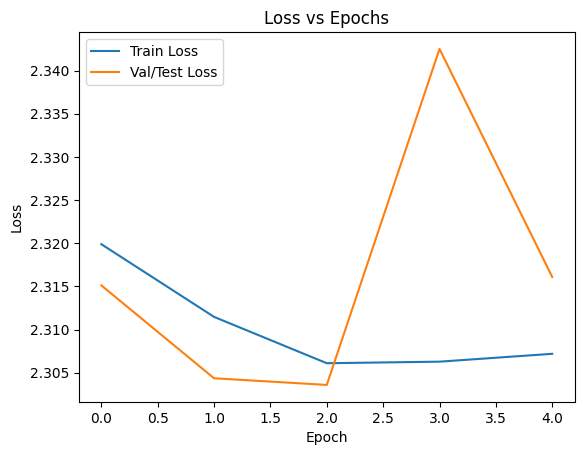

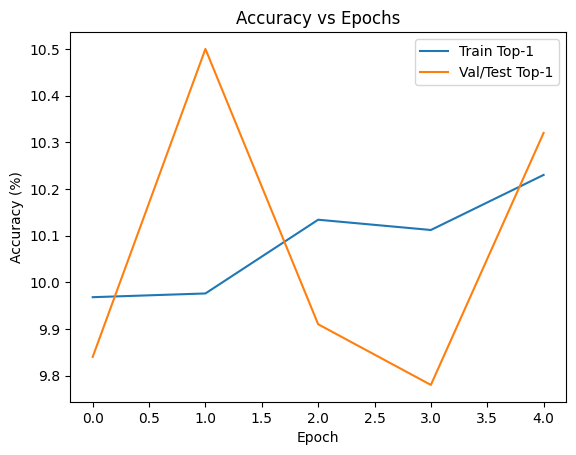

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▂█▂▁▆
train_acc,▁▁▅▅█
train_loss,█▄▁▁▂
val_acc,▂█▂▁▆
val_loss,▃▁▁█▃
weight_bit_width,▁▁▁▁▁
activation_bit_width,2


wandb: Agent Starting Run: ov9upcdw with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 2
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 2
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=2, activation_bit_width=4, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 0.704 MB
Compression ratio (FP32 / quantized): 12.12x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.2998 | Top-1: 12.88%
Epoch [0] Step [200/391] Loss: 2.2410 | Top-1: 16.34%
Epoch [0] Step [300/391] Loss: 2.1823 | Top-1: 19.47%
Epoch [0] TRAIN - Loss: 2.1422 | Top-1: 21.75% | Time: 284.9s
Epoch [0] VALID - Loss: 1.9400 | Top-1: 36.39%
New best acc: 36.39%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 1.9523 | Top-1: 32.91%
Epoch [1] Step [200/391] Loss: 1.9183 | Top-1: 34.38%
Epoch [1] Step [300/391] Loss: 1.8945 | Top-1: 35.55%
Epoch [1] TRAIN - Loss: 1.8702 | Top-1: 36.92% | Time: 284.5s
Epoch [1] VALID - Loss: 1.6556 | Top-1: 48.51%
New best acc: 48.51%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Ep

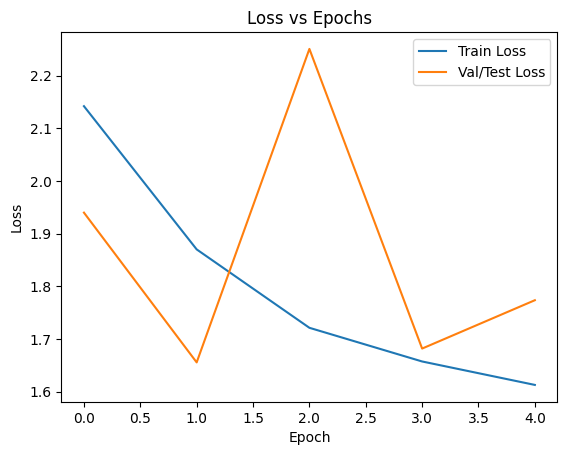

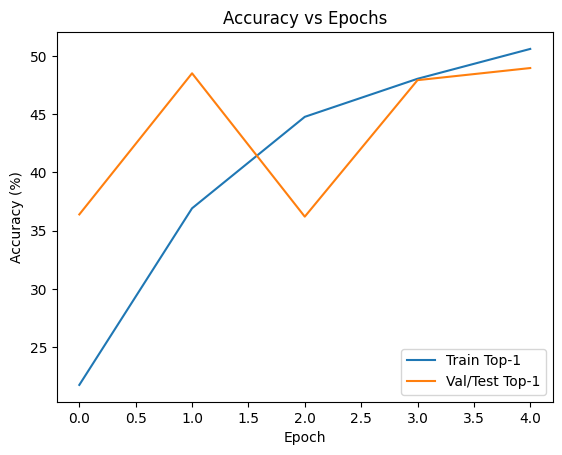

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁█▁▇█
train_acc,▁▅▇▇█
train_loss,█▄▂▂▁
val_acc,▁█▁▇█
val_loss,▄▁█▁▂
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


wandb: Agent Starting Run: vvy1vpy1 with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 4
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 4
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=4, activation_bit_width=4, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 1.226 MB
Compression ratio (FP32 / quantized): 6.96x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 1.4030 | Top-1: 71.84%
Epoch [0] Step [200/391] Loss: 1.2529 | Top-1: 74.34%
Epoch [0] Step [300/391] Loss: 1.1919 | Top-1: 75.66%
Epoch [0] TRAIN - Loss: 1.1543 | Top-1: 76.68% | Time: 286.1s
Epoch [0] VALID - Loss: 0.8479 | Top-1: 88.08%
New best acc: 88.08%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 1.0060 | Top-1: 81.23%
Epoch [1] Step [200/391] Loss: 1.0026 | Top-1: 81.04%
Epoch [1] Step [300/391] Loss: 0.9978 | Top-1: 81.14%
Epoch [1] TRAIN - Loss: 0.9910 | Top-1: 81.44% | Time: 285.9s
Epoch [1] VALID - Loss: 0.7900 | Top-1: 89.89%
New best acc: 89.89%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epo

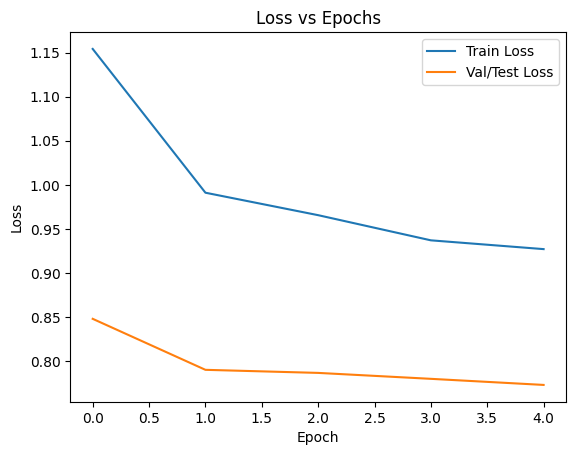

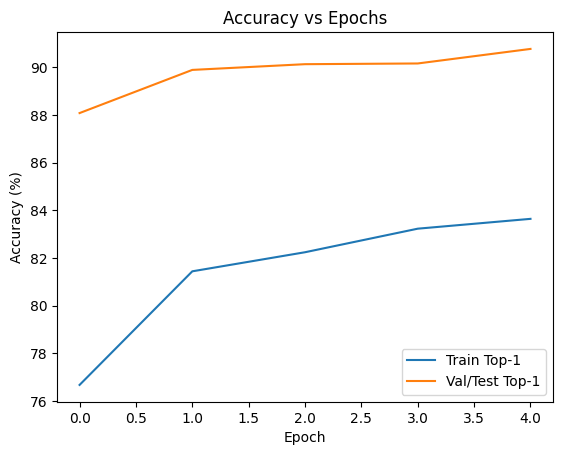

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▆▆▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▆▆█
val_loss,█▃▂▂▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


wandb: Agent Starting Run: 1pxpo0qa with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=4, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.231 MB
Compression ratio (FP32 / quantized): 3.82x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 1.4292 | Top-1: 70.47%
Epoch [0] Step [200/391] Loss: 1.2632 | Top-1: 73.97%
Epoch [0] Step [300/391] Loss: 1.1991 | Top-1: 75.36%
Epoch [0] TRAIN - Loss: 1.1593 | Top-1: 76.46% | Time: 288.6s
Epoch [0] VALID - Loss: 0.8261 | Top-1: 89.03%
New best acc: 89.03%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 1.0091 | Top-1: 80.35%
Epoch [1] Step [200/391] Loss: 1.0007 | Top-1: 80.73%
Epoch [1] Step [300/391] Loss: 0.9910 | Top-1: 81.30%
Epoch [1] TRAIN - Loss: 0.9860 | Top-1: 81.48% | Time: 288.1s
Epoch [1] VALID - Loss: 0.7841 | Top-1: 90.43%
New best acc: 90.43%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoc

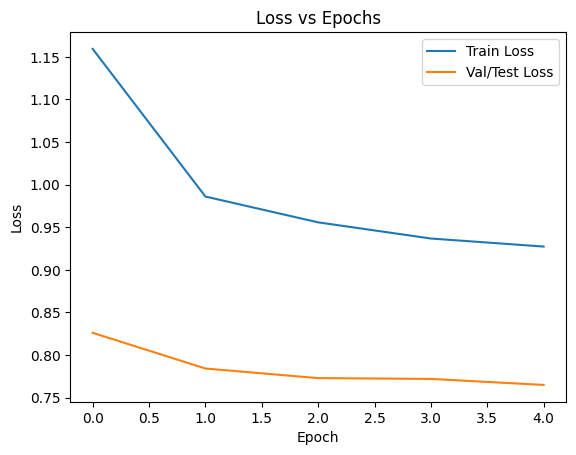

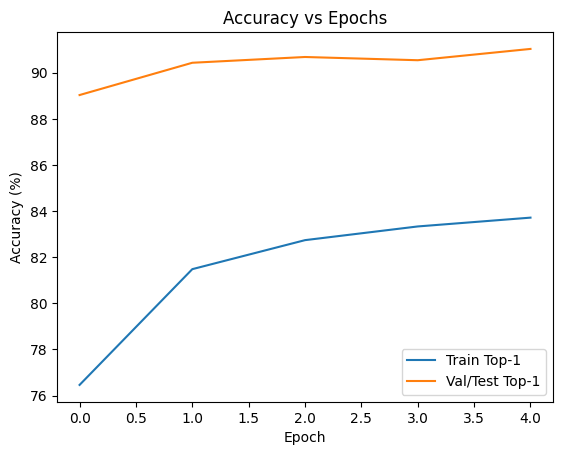

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▆▇▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇▆█
val_loss,█▃▂▂▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


wandb: Agent Starting Run: xwydvmh1 with config:
wandb: 	activation_bit_width: 8
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 8
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=8, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.231 MB
Compression ratio (FP32 / quantized): 3.82x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 0.6686 | Top-1: 94.97%
Epoch [0] Step [200/391] Loss: 0.6713 | Top-1: 94.87%
Epoch [0] Step [300/391] Loss: 0.6714 | Top-1: 94.89%
Epoch [0] TRAIN - Loss: 0.6706 | Top-1: 94.88% | Time: 289.4s
Epoch [0] VALID - Loss: 0.6351 | Top-1: 96.08%
New best acc: 96.08%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 0.6693 | Top-1: 95.02%
Epoch [1] Step [200/391] Loss: 0.6735 | Top-1: 94.79%
Epoch [1] Step [300/391] Loss: 0.6728 | Top-1: 94.80%
Epoch [1] TRAIN - Loss: 0.6701 | Top-1: 94.94% | Time: 289.2s
Epoch [1] VALID - Loss: 0.6335 | Top-1: 96.20%
New best acc: 96.20%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoc

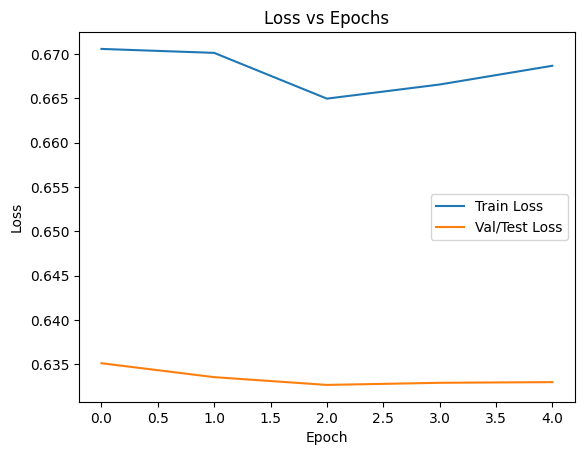

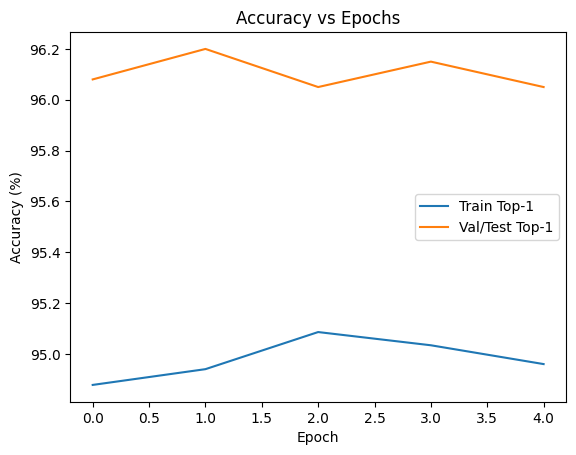

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▂█▁▆▁
train_acc,▁▃█▆▄
train_loss,█▇▁▃▆
val_acc,▂█▁▆▁
val_loss,█▄▁▂▂
weight_bit_width,▁▁▁▁▁
activation_bit_width,8


wandb: Agent Starting Run: 9gfsx354 with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=2, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.270 MB
Compression ratio (FP32 / quantized): 3.76x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: nan | Top-1: 9.98%
Epoch [0] Step [200/391] Loss: nan | Top-1: 9.90%
Epoch [0] Step [300/391] Loss: nan | Top-1: 9.91%
Epoch [0] TRAIN - Loss: nan | Top-1: 9.99% | Time: 272.1s
Epoch [0] VALID - Loss: nan | Top-1: 10.00%
New best acc: 10.00%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: nan | Top-1: 10.14%
Epoch [1] Step [200/391] Loss: nan | Top-1: 9.97%
Epoch [1] Step [300/391] Loss: nan | Top-1: 9.96%
Epoch [1] TRAIN - Loss: nan | Top-1: 10.00% | Time: 271.9s
Epoch [1] VALID - Loss: nan | Top-1: 10.00%

=== Epoch 2/4 ===
Epoch [2] Step [100/391] Loss: nan | Top-1: 10.12%
Epoch [2] Step [200/391] Loss: nan | Top-1: 10.06%
Epoch 

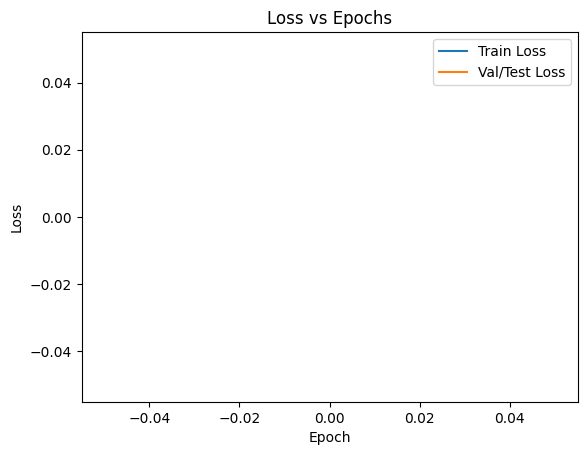

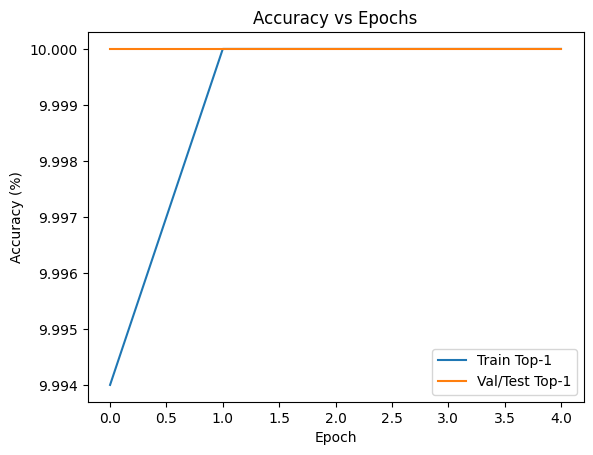

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▁▁▁▁
train_acc,▁████
val_acc,▁▁▁▁▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,2
best_val_acc,10
compression_ratio,3.75907


wandb: Agent Starting Run: 3bp3ynr9 with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=2, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.231 MB
Compression ratio (FP32 / quantized): 3.82x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.3299 | Top-1: 9.96%
Epoch [0] Step [200/391] Loss: 2.3252 | Top-1: 10.05%
Epoch [0] Step [300/391] Loss: 2.3228 | Top-1: 10.11%
Epoch [0] TRAIN - Loss: 2.3215 | Top-1: 10.02% | Time: 280.1s
Epoch [0] VALID - Loss: 2.3196 | Top-1: 10.05%
New best acc: 10.05%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 2.3158 | Top-1: 10.02%
Epoch [1] Step [200/391] Loss: 2.3163 | Top-1: 9.95%
Epoch [1] Step [300/391] Loss: 2.3153 | Top-1: 10.04%
Epoch [1] TRAIN - Loss: 2.3144 | Top-1: 9.93% | Time: 280.0s
Epoch [1] VALID - Loss: 2.3110 | Top-1: 10.15%
New best acc: 10.15%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 2

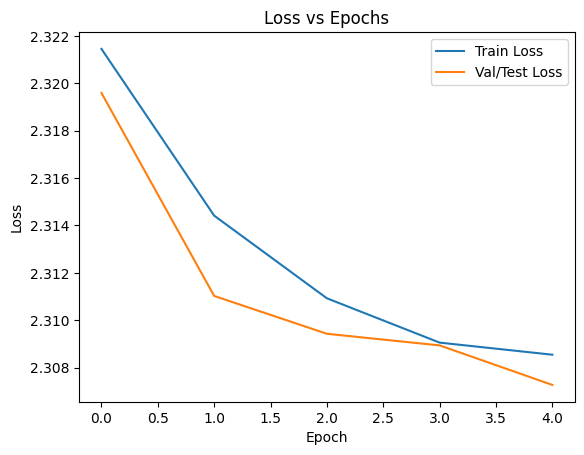

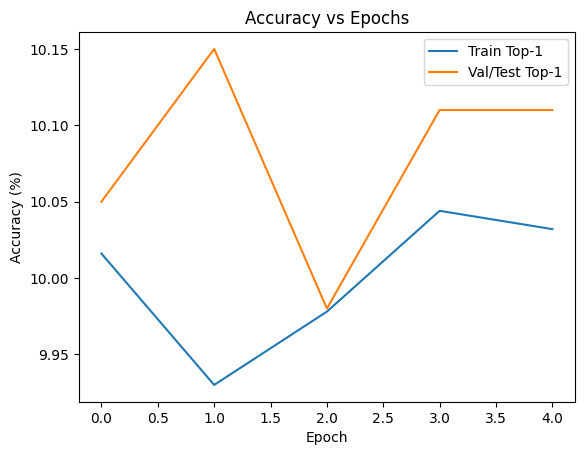

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▄█▁▆▆
train_acc,▆▁▄█▇
train_loss,█▄▂▁▁
val_acc,▄█▁▆▆
val_loss,█▃▂▂▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,2


wandb: Agent Starting Run: 6pb099pk with config:
wandb: 	activation_bit_width: 8
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 2
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 2
activation_bit_width: 8
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=2, activation_bit_width=8, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 0.655 MB
Compression ratio (FP32 / quantized): 13.02x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.2398 | Top-1: 18.59%
Epoch [0] Step [200/391] Loss: 2.1172 | Top-1: 24.67%
Epoch [0] Step [300/391] Loss: 2.0232 | Top-1: 29.43%
Epoch [0] TRAIN - Loss: 1.9607 | Top-1: 32.54% | Time: 289.4s
Epoch [0] VALID - Loss: 1.5368 | Top-1: 53.30%
New best acc: 53.30%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 1.6919 | Top-1: 46.26%
Epoch [1] Step [200/391] Loss: 1.6604 | Top-1: 47.79%
Epoch [1] Step [300/391] Loss: 1.6403 | Top-1: 49.01%
Epoch [1] TRAIN - Loss: 1.6230 | Top-1: 49.88% | Time: 289.2s
Epoch [1] VALID - Loss: 1.3332 | Top-1: 64.17%
New best acc: 64.17%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epo

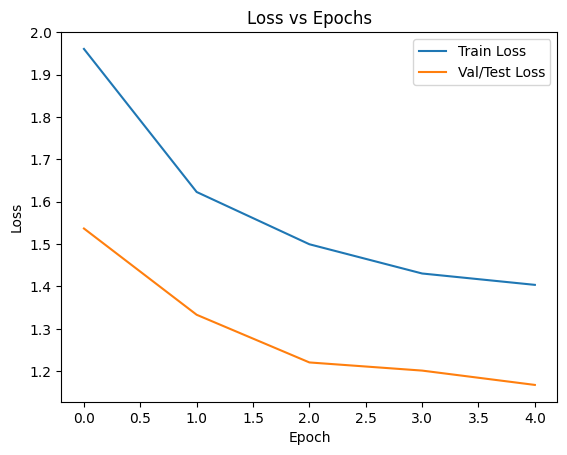

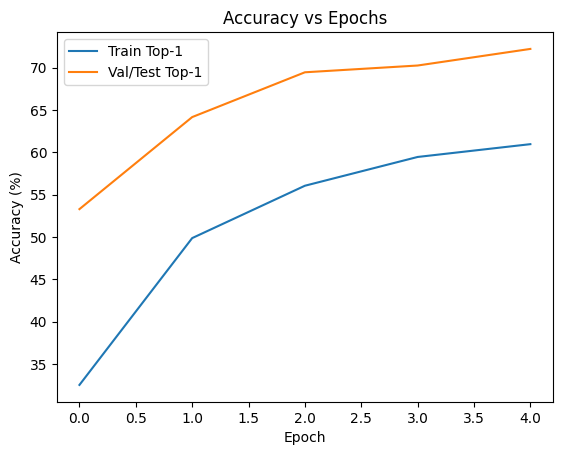

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▅▇▇█
train_acc,▁▅▇██
train_loss,█▄▂▁▁
val_acc,▁▅▇▇█
val_loss,█▄▂▂▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,8


wandb: Agent Starting Run: gqjnjhk6 with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 2
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 2
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=2, activation_bit_width=4, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 0.704 MB
Compression ratio (FP32 / quantized): 12.12x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.2918 | Top-1: 13.73%
Epoch [0] Step [200/391] Loss: 2.2362 | Top-1: 17.14%
Epoch [0] Step [300/391] Loss: 2.1890 | Top-1: 19.76%
Epoch [0] TRAIN - Loss: 2.1521 | Top-1: 21.70% | Time: 285.8s
Epoch [0] VALID - Loss: 1.9897 | Top-1: 37.02%
New best acc: 37.02%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 2.0307 | Top-1: 31.12%
Epoch [1] Step [200/391] Loss: 1.9715 | Top-1: 32.73%
Epoch [1] Step [300/391] Loss: 1.9315 | Top-1: 34.43%
Epoch [1] TRAIN - Loss: 1.9004 | Top-1: 35.98% | Time: 285.8s
Epoch [1] VALID - Loss: 1.8306 | Top-1: 48.04%
New best acc: 48.04%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Ep

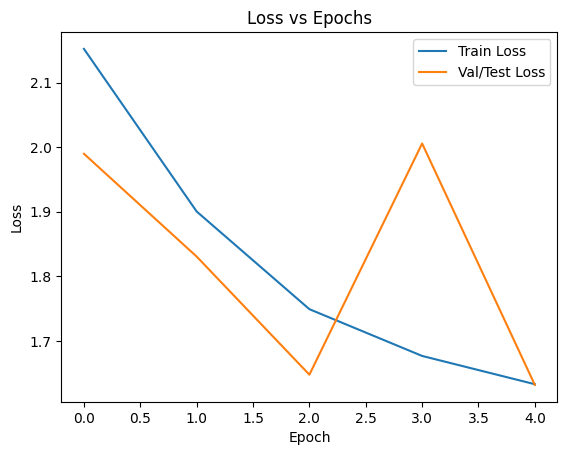

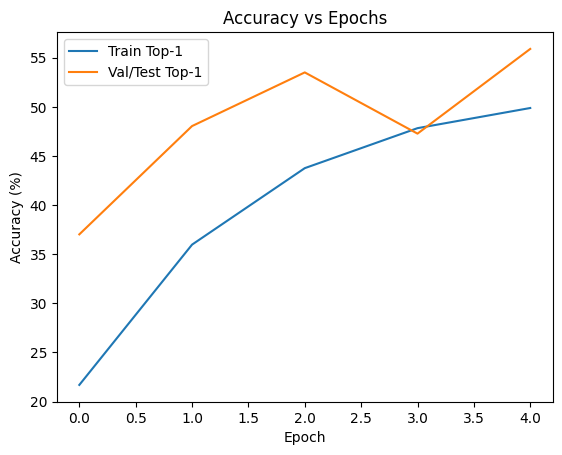

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▅▇▅█
train_acc,▁▅▆▇█
train_loss,█▅▃▂▁
val_acc,▁▅▇▅█
val_loss,█▅▁█▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: adbige2s with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 2
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 2
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=2, activation_bit_width=2, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 0.655 MB
Compression ratio (FP32 / quantized): 13.02x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: nan | Top-1: 9.78%
Epoch [0] Step [200/391] Loss: nan | Top-1: 9.70%
Epoch [0] Step [300/391] Loss: nan | Top-1: 9.85%
Epoch [0] TRAIN - Loss: nan | Top-1: 9.95% | Time: 276.3s
Epoch [0] VALID - Loss: nan | Top-1: 10.00%
New best acc: 10.00%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: nan | Top-1: 9.66%
Epoch [1] Step [200/391] Loss: nan | Top-1: 9.69%
Epoch [1] Step [300/391] Loss: nan | Top-1: 9.88%
Epoch [1] TRAIN - Loss: nan | Top-1: 10.00% | Time: 276.0s
Epoch [1] VALID - Loss: nan | Top-1: 10.00%

=== Epoch 2/4 ===
Epoch [2] Step [100/391] Loss: nan | Top-1: 9.99%
Epoch [2] Step [200/391] Loss: nan | Top-1: 10.10%
Epoch [2

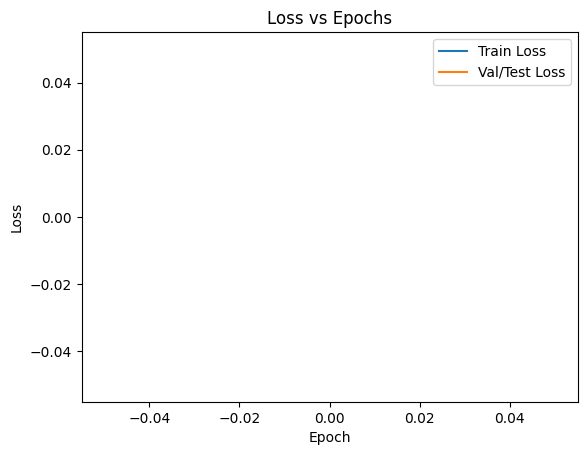

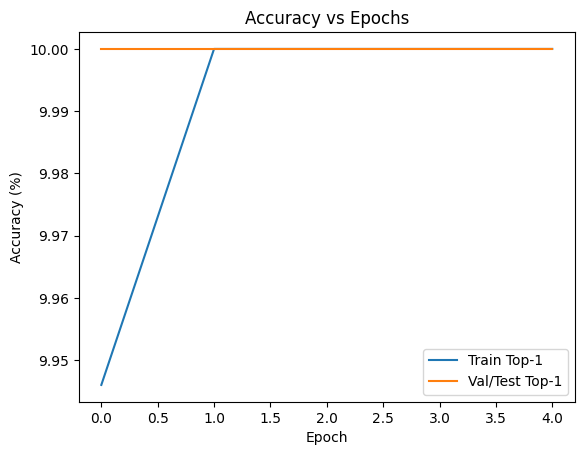

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▁▁▁▁
train_acc,▁████
val_acc,▁▁▁▁▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,2
best_val_acc,10
compression_ratio,13.02047


wandb: Agent Starting Run: nyohdo5o with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=4, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.270 MB
Compression ratio (FP32 / quantized): 3.76x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 1.3836 | Top-1: 73.23%
Epoch [0] Step [200/391] Loss: 1.2436 | Top-1: 75.11%
Epoch [0] Step [300/391] Loss: 1.1794 | Top-1: 76.50%
Epoch [0] TRAIN - Loss: 1.1425 | Top-1: 77.45% | Time: 287.3s
Epoch [0] VALID - Loss: 0.8315 | Top-1: 89.34%
New best acc: 89.34%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 0.9903 | Top-1: 81.59%
Epoch [1] Step [200/391] Loss: 0.9870 | Top-1: 81.75%
Epoch [1] Step [300/391] Loss: 0.9792 | Top-1: 82.05%
Epoch [1] TRAIN - Loss: 0.9753 | Top-1: 82.26% | Time: 286.3s
Epoch [1] VALID - Loss: 0.7847 | Top-1: 90.67%
New best acc: 90.67%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epo

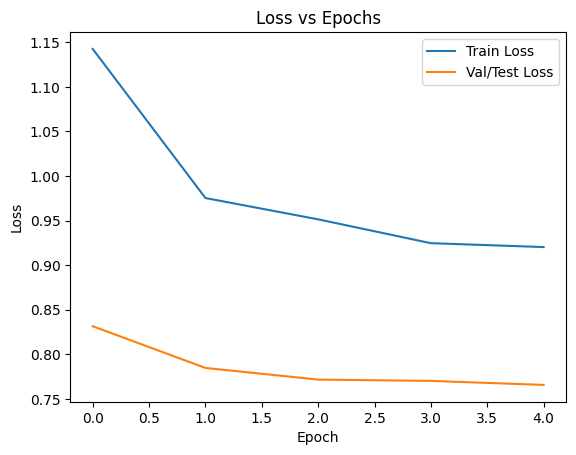

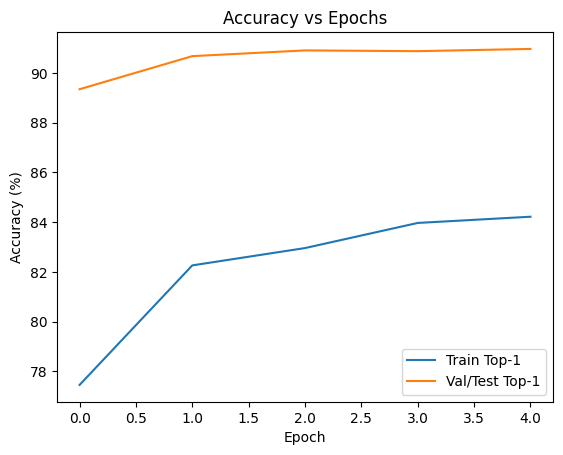

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▇███
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▁▇███
val_loss,█▃▂▁▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oge2bi7a with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=2, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.231 MB
Compression ratio (FP32 / quantized): 3.82x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.3280 | Top-1: 10.00%
Epoch [0] Step [200/391] Loss: 2.3251 | Top-1: 10.03%
Epoch [0] Step [300/391] Loss: 2.3224 | Top-1: 10.16%
Epoch [0] TRAIN - Loss: 2.3208 | Top-1: 10.08% | Time: 282.2s
Epoch [0] VALID - Loss: 2.3313 | Top-1: 10.38%
New best acc: 10.38%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 2.3171 | Top-1: 10.34%
Epoch [1] Step [200/391] Loss: 2.3150 | Top-1: 10.24%
Epoch [1] Step [300/391] Loss: 2.3136 | Top-1: 10.11%
Epoch [1] TRAIN - Loss: 2.3132 | Top-1: 10.17% | Time: 282.1s
Epoch [1] VALID - Loss: 2.3151 | Top-1: 10.22%

=== Epoch 2/4 ===
Epoch [2] Step [100/391] Loss: 2.3098 | Top-1: 9.91%
Epoch [2] Step [200/

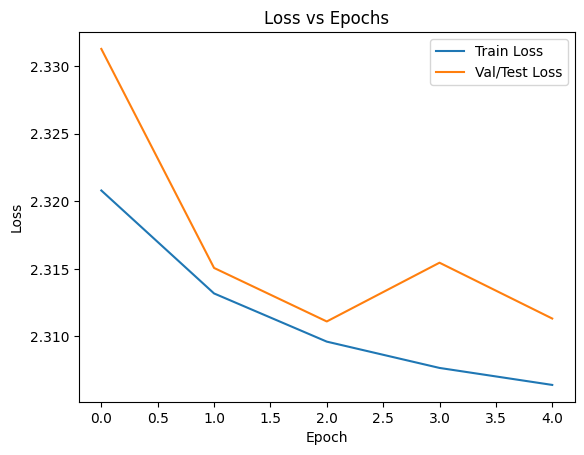

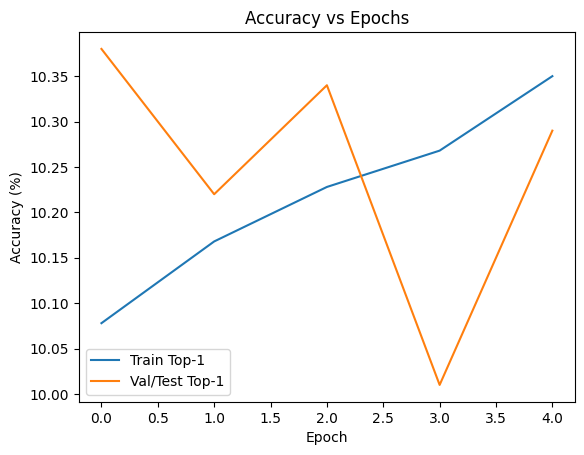

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,█▅▇▁▆
train_acc,▁▃▅▆█
train_loss,█▄▃▂▁
val_acc,█▅▇▁▆
val_loss,█▂▁▃▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,2


wandb: Agent Starting Run: ka978ey0 with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 2
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 2
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=2, activation_bit_width=2, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 0.655 MB
Compression ratio (FP32 / quantized): 13.02x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: nan | Top-1: 9.80%
Epoch [0] Step [200/391] Loss: nan | Top-1: 9.76%
Epoch [0] Step [300/391] Loss: nan | Top-1: 9.89%
Epoch [0] TRAIN - Loss: nan | Top-1: 9.92% | Time: 277.6s
Epoch [0] VALID - Loss: nan | Top-1: 10.00%
New best acc: 10.00%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: nan | Top-1: 10.11%
Epoch [1] Step [200/391] Loss: nan | Top-1: 10.12%
Epoch [1] Step [300/391] Loss: nan | Top-1: 10.02%
Epoch [1] TRAIN - Loss: nan | Top-1: 10.00% | Time: 277.2s
Epoch [1] VALID - Loss: nan | Top-1: 10.00%

=== Epoch 2/4 ===
Epoch [2] Step [100/391] Loss: nan | Top-1: 9.79%
Epoch [2] Step [200/391] Loss: nan | Top-1: 9.93%
Epoch 

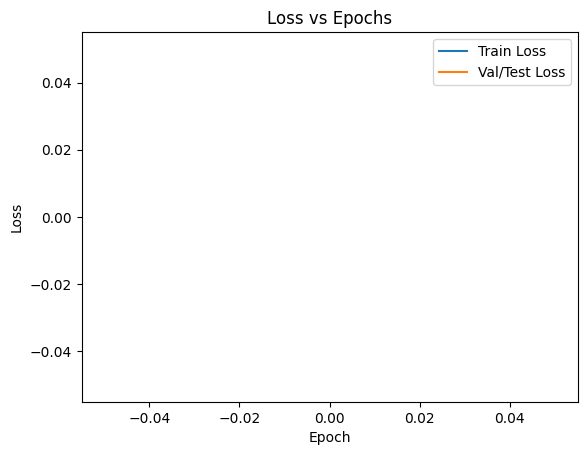

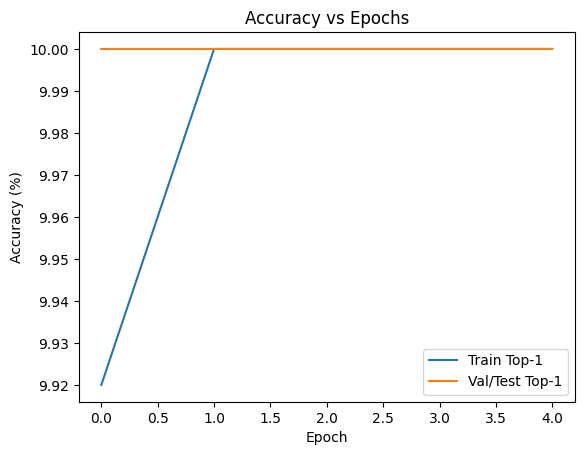

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▁▁▁▁
train_acc,▁████
val_acc,▁▁▁▁▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,2
best_val_acc,10
compression_ratio,13.02047


wandb: Agent Starting Run: mevty7uu with config:
wandb: 	activation_bit_width: 2
wandb: 	lr: 0.001
wandb: 	quantize_first_last: False
wandb: 	weight_bit_width: 4
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 4
activation_bit_width: 2
lr: 0.001
weight_decay: 4e-05
quantize_first_last: False


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=4, activation_bit_width=2, quantize_first_last=False
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 1.226 MB
Compression ratio (FP32 / quantized): 6.96x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: nan | Top-1: 9.76%
Epoch [0] Step [200/391] Loss: nan | Top-1: 9.81%
Epoch [0] Step [300/391] Loss: nan | Top-1: 9.93%
Epoch [0] TRAIN - Loss: nan | Top-1: 9.99% | Time: 275.0s
Epoch [0] VALID - Loss: nan | Top-1: 10.00%
New best acc: 10.00%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: nan | Top-1: 10.12%
Epoch [1] Step [200/391] Loss: nan | Top-1: 9.91%
Epoch [1] Step [300/391] Loss: nan | Top-1: 10.00%
Epoch [1] TRAIN - Loss: nan | Top-1: 10.00% | Time: 274.1s
Epoch [1] VALID - Loss: nan | Top-1: 10.00%

=== Epoch 2/4 ===
Epoch [2] Step [100/391] Loss: nan | Top-1: 10.12%
Epoch [2] Step [200/391] Loss: nan | Top-1: 9.96%
Epoch 

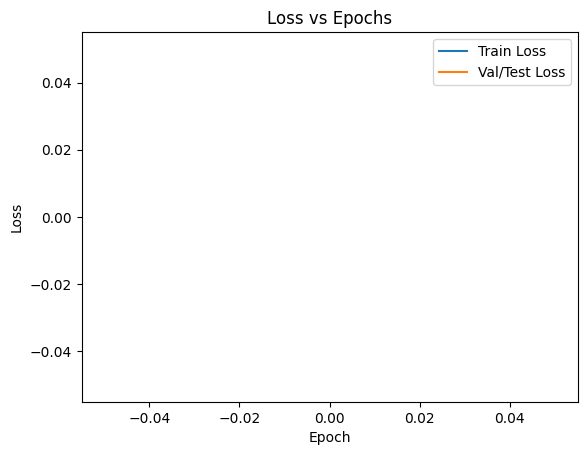

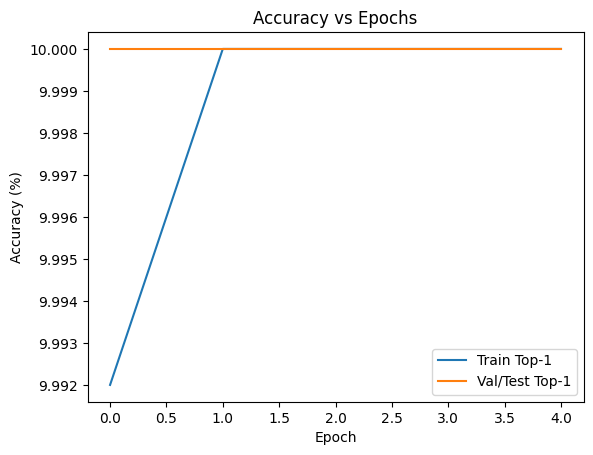

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▁▁▁▁
train_acc,▁████
val_acc,▁▁▁▁▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,2
best_val_acc,10
compression_ratio,6.95923


wandb: Agent Starting Run: ms4beza0 with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 8
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 8
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=8, activation_bit_width=4, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 2.231 MB
Compression ratio (FP32 / quantized): 3.82x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 1.4124 | Top-1: 71.40%
Epoch [0] Step [200/391] Loss: 1.2587 | Top-1: 74.24%
Epoch [0] Step [300/391] Loss: 1.1896 | Top-1: 75.90%
Epoch [0] TRAIN - Loss: 1.1560 | Top-1: 76.64% | Time: 290.8s
Epoch [0] VALID - Loss: 0.8188 | Top-1: 89.65%
New best acc: 89.65%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 1.0110 | Top-1: 80.57%
Epoch [1] Step [200/391] Loss: 1.0038 | Top-1: 80.98%
Epoch [1] Step [300/391] Loss: 1.0007 | Top-1: 81.00%
Epoch [1] TRAIN - Loss: 0.9949 | Top-1: 81.30% | Time: 290.3s
Epoch [1] VALID - Loss: 0.7928 | Top-1: 90.06%
New best acc: 90.06%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoc

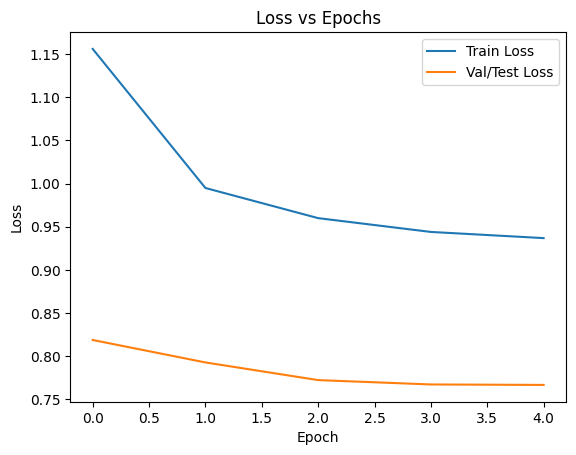

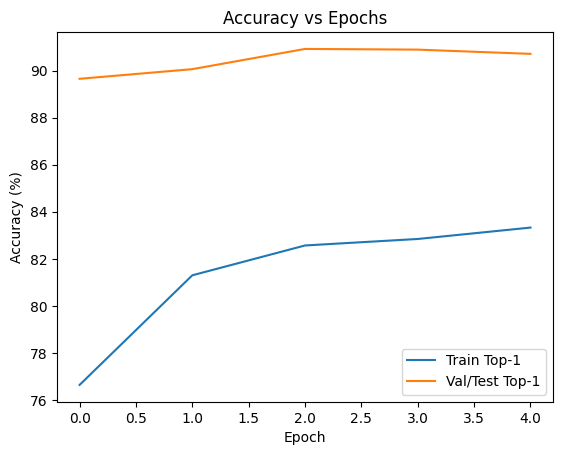

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▃██▇
train_acc,▁▆▇▇█
train_loss,█▃▂▁▁
val_acc,▁▃██▇
val_loss,█▅▂▁▁
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


wandb: Agent Starting Run: owdvzmes with config:
wandb: 	activation_bit_width: 4
wandb: 	lr: 0.001
wandb: 	quantize_first_last: True
wandb: 	weight_bit_width: 2
wandb: 	weight_decay: 4e-05



[SWEEP RUN CONFIG]
weight_bit_width: 2
activation_bit_width: 4
lr: 0.001
weight_decay: 4e-05
quantize_first_last: True


Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=2, activation_bit_width=4, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 0.655 MB
Compression ratio (FP32 / quantized): 13.02x

=== Epoch 0/4 ===
Epoch [0] Step [100/391] Loss: 2.3103 | Top-1: 12.21%
Epoch [0] Step [200/391] Loss: 2.2673 | Top-1: 14.67%
Epoch [0] Step [300/391] Loss: 2.2183 | Top-1: 16.81%
Epoch [0] TRAIN - Loss: 2.1850 | Top-1: 18.68% | Time: 288.3s
Epoch [0] VALID - Loss: 2.0360 | Top-1: 27.13%
New best acc: 27.13%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epoch 1/4 ===
Epoch [1] Step [100/391] Loss: 2.0414 | Top-1: 26.66%
Epoch [1] Step [200/391] Loss: 2.0259 | Top-1: 27.57%
Epoch [1] Step [300/391] Loss: 2.0099 | Top-1: 28.79%
Epoch [1] TRAIN - Loss: 1.9936 | Top-1: 29.85% | Time: 288.5s
Epoch [1] VALID - Loss: 1.9587 | Top-1: 39.98%
New best acc: 39.98%. Saved checkpoint to mobilenetv2_cifar10_best_compressed.pth.

=== Epo

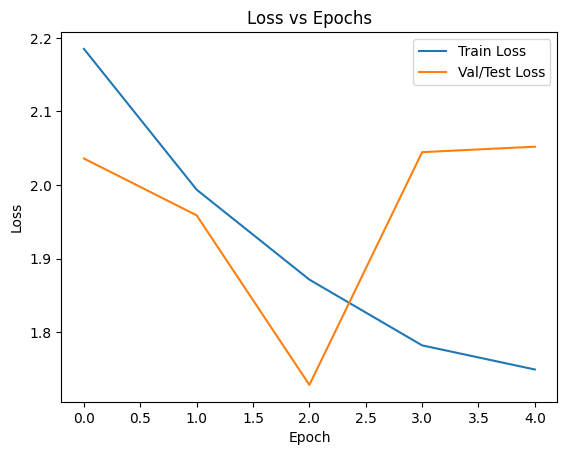

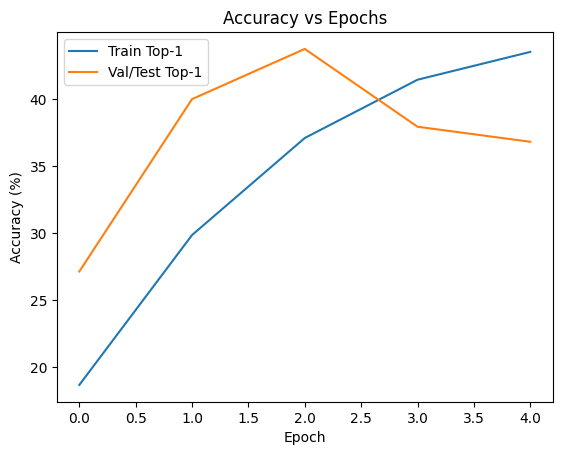

activation_bit_width,▁▁▁▁▁
compression_ratio,▁▁▁▁▁
epoch,▁▃▅▆█
model_size_mb,▁▁▁▁▁
test_accuracy,▁▆█▆▅
train_acc,▁▄▆▇█
train_loss,█▅▃▂▁
val_acc,▁▆█▆▅
val_loss,█▆▁██
weight_bit_width,▁▁▁▁▁
activation_bit_width,4


In [12]:
# -------------------------------
# W&B Sweep configuration & agent
# -------------------------------
sweep_config = {
    "method": "random",  # or "grid", "random"
    "metric": {
        "name": "test_accuracy",  # we logged this in wandb.log
        "goal": "maximize",
    },
    "parameters": {
        "weight_bit_width": {
            "values": [2, 4, 8],
        },
        "activation_bit_width": {
            "values": [2, 4, 8],
        },
        "lr": {
            "values": [0.001],
        },
        "weight_decay": {
            "values": [4e-5],
        },
        "quantize_first_last": {
            "values": [True, False]
        },
    },
}


def sweep_train():
    run = wandb.init()
    wb_cfg = wandb.config

    cfg.weight_bit_width = wb_cfg.weight_bit_width
    cfg.activation_bit_width = wb_cfg.activation_bit_width
    cfg.lr = wb_cfg.lr
    cfg.weight_decay = wb_cfg.weight_decay
    cfg.quantize_first_last = wb_cfg.quantize_first_last 

    print("\n[SWEEP RUN CONFIG]")
    print("weight_bit_width:", cfg.weight_bit_width)
    print("activation_bit_width:", cfg.activation_bit_width)
    print("lr:", cfg.lr)
    print("weight_decay:", cfg.weight_decay)
    print("quantize_first_last:", cfg.quantize_first_last)

    train_and_eval(cfg)


# Create the sweep (only once)
sweep_id = wandb.sweep(
    sweep=sweep_config,
    project=cfg.wandb_project,
    entity=cfg.wandb_entity,
)
print("Created W&B sweep with id:", sweep_id)

# Launch agent to run multiple configs (you can choose count)
wandb.agent(
    sweep_id,
    function=sweep_train,
    count=16,  # how many runs you want
)

Using device: cuda
Load ImageNet weights
Applying QAT: weight_bit_width=4, activation_bit_width=8, quantize_first_last=True
Estimated FP32 model size: 8.532 MB
Estimated quantized model size: 1.180 MB
Compression ratio (FP32 / quantized): 7.23x

=== Epoch 0/14 ===
Epoch [0] Step [100/391] Loss: 0.7096 | Top-1: 93.17%
Epoch [0] Step [200/391] Loss: 0.7077 | Top-1: 93.18%
Epoch [0] Step [300/391] Loss: 0.7062 | Top-1: 93.24%
Epoch [0] TRAIN - Loss: 0.7053 | Top-1: 93.27% | Time: 281.4s
Epoch [0] VALID - Loss: 0.6971 | Top-1: 93.42%
New best acc: 93.42%. Saved checkpoint to mobilenetv2_cifar10_qat_4w8a.pth.

=== Epoch 1/14 ===
Epoch [1] Step [100/391] Loss: 0.7074 | Top-1: 93.23%
Epoch [1] Step [200/391] Loss: 0.7063 | Top-1: 93.26%
Epoch [1] Step [300/391] Loss: 0.7062 | Top-1: 93.27%
Epoch [1] TRAIN - Loss: 0.7047 | Top-1: 93.34% | Time: 281.1s
Epoch [1] VALID - Loss: 0.6698 | Top-1: 94.46%
New best acc: 94.46%. Saved checkpoint to mobilenetv2_cifar10_qat_4w8a.pth.

=== Epoch 2/14 ===
E

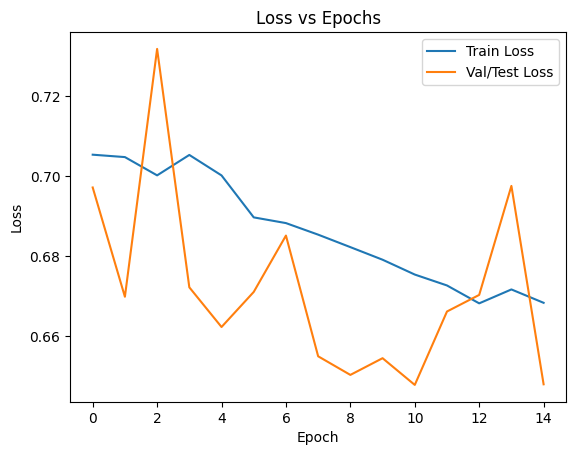

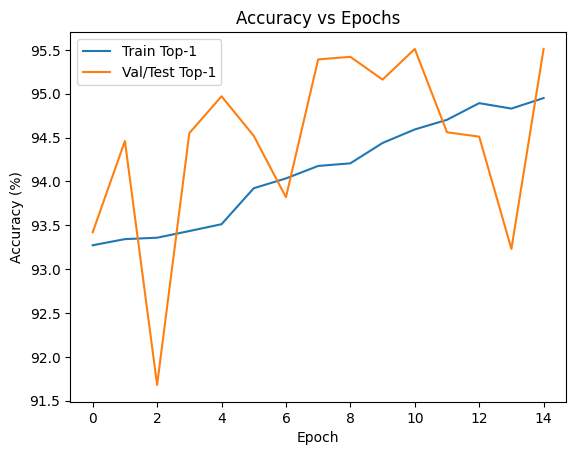

Best QAT 4w/8a accuracy: 95.51


In [17]:
# Configure a simple 4w/8a QAT fine-tuning run

cfg = Config()

# Use your FP32 pretrained model
cfg.no_pretrained = False                      # still okay to keep ImageNet init in create_mobilenetv2_cifar10
cfg.use_qat = True

# QAT format
cfg.weight_bit_width = 4                       # 4-bit weights
cfg.activation_bit_width = 8                   # 8-bit activations
cfg.quantize_first_last = True                 # quantize first conv & last linear

# Training settings for QAT fine-tuning
cfg.epochs = 15                                # “a couple” of epochs
cfg.lr = 0.005                                 # smaller LR than baseline training
cfg.weight_decay = 4e-5
cfg.batch_size = 128

# Logging / checkpoint
cfg.use_wandb = False                          # disable W&B for simplicity
cfg.save_path = "mobilenetv2_cifar10_qat_4w8a.pth"

history, best_acc = train_and_eval(cfg)
print("Best QAT 4w/8a accuracy:", best_acc)